# Template

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter
from matplotlib.patches import FancyArrowPatch, Arc

plt.style.use('science')
plt.rcParams.update({'font.size': 14})

# Versuch 1

In [73]:
# Signal : TTI 1604, Metex 4600, Fluke 175, Keysight 2002 Oszilloskop
Ueff_sine = [2.071, 2.069, 2.071, 2.0751] #V
Ueff_drei = [1.746, 1.665, 1.745, 1.7473] #V
Ueff_rect = [3.256, 3.573, 3.251, 3.2566] #V

dU_TTI = lambda u: 0.005*u + 0.004 
dU_Metex = lambda u: 0.005*u + 0.01
dU_Fluke = lambda u: 0.01*u + 0.003

U_pp = [6, 6.1, 6.7] #V
f = 50 #Hz

Ueff_sine_theorie = U_pp[0] / (2*np.sqrt(2))
Ueff_drei_theorie = U_pp[1] / (2*np.sqrt(3))
Ueff_rect_theorie = U_pp[2] / 2

table_text = rf"""
Signal & TTI 1604 & Metex 4600 & Fluke 175 & Keysight X2002A & Theorie \\\hline
Sinus & {Ueff_sine[0]:.3f} \pm {dU_TTI(Ueff_sine[0]):.4f} & {Ueff_sine[1]:.3f} \pm {dU_Metex(Ueff_sine[1]):.4f} & {Ueff_sine[2]:.3f} \pm {dU_Fluke(Ueff_sine[2]):.4f} & {Ueff_sine[3]:.2f} & {Ueff_sine_theorie} \\
Dreieck & {Ueff_drei[0]:.3f} \pm {dU_TTI(Ueff_drei[0]):.4f} & {Ueff_drei[1]:.3f} \pm {dU_Metex(Ueff_drei[1]):.4f} & {Ueff_drei[2]:.3f} \pm {dU_Fluke(Ueff_drei[2]):.4f} & {Ueff_drei[3]:.2f} & {Ueff_drei_theorie} \\
Rechteck & {Ueff_rect[0]:.3f} \pm {dU_TTI(Ueff_rect[0]):.4f} & {Ueff_rect[1]:.3f} \pm {dU_Metex(Ueff_rect[1]):.4f} & {Ueff_rect[2]:.3f} \pm {dU_Fluke(Ueff_rect[2]):.4f} & {Ueff_rect[3]:.2f} & {Ueff_rect_theorie} \\
"""

print(table_text)


Signal & TTI 1604 & Metex 4600 & Fluke 175 & Keysight X2002A & Theorie \\\hline
Sinus & 2.071 \pm 0.0144 & 2.069 \pm 0.0203 & 2.071 \pm 0.0237 & 2.08 & 2.1213203435596424 \\
Dreieck & 1.746 \pm 0.0127 & 1.665 \pm 0.0183 & 1.745 \pm 0.0204 & 1.75 & 1.7609183210283585 \\
Rechteck & 3.256 \pm 0.0203 & 3.573 \pm 0.0279 & 3.251 \pm 0.0355 & 3.26 & 3.35 \\



# Versuch 2

In [281]:
data = """
i & $f_Oszi / Hz & $U1$  &  $U2   & $U3$   & $U_Oszi$
1 & 10      & 2,050 &  2,136 & 2,059  & 2,089
2 & 20      & 2,086 &  2,112 & 2,079  & 2,09 
3 & 39,99   & 2,089 &  2,089 & 2,087  & 2,089
4 & 60      & 2,094 &  2,086 & 2,092  & 2,092
5 & 50,02   & 2,091 &  2,095 & 2,089  & 2,091
6 & 80      & 2,088 &  2,077 & 2,088  & 2,088
7 & 100     & 2,089 &  2,076 & 2,088  & 2,088
8 & 200     & 2,087 &  2,072 & 2,086  & 2,088
9 & 400     & 2,087 &  2,075 & 2,084  & 2,089
10 & 500    & 2,087 &  2,080 & 2,083  & 2,088
11 & 600    & 2,083 &  2,080 & 2,076  & 2,086
12 & 800    & 2,082 &  2,086 & 2,07   & 2,085
13 & 1000   & 2,080 &  2,098 & 2,062  & 2,085
14 & 2000   & 2,074 &  2,212 & 1,998  & 2,086
15 & 4000   & 2,069 &  2,624 & 1,792  & 2,087
16 & 5000   & 2,069 &  2,895 & 1,672  & 2,084
17 & 6000   & 2,066 &  3,174 & 1,554  & 2,085
18 & 8000   & 2,067 &  3,787 & 1,337  & 2,084
19 & 10000  & 2,069 &  4,415 & 1,154  & 2,084
20 & 20000  & 2,084 &  7,253 & 0,614  & 2,079
21 & 40000  & 2,122 & 10,788 & 0,3074 & 2,062
22 & 50000  & 2,152 & 11,827 & 0,2372 & 2,059
23 & 60000  & 2,177 & 12,465 & 0,1881 & 2,048
24 & 80000  & 2,231 & 12,951 & 0,1288 & 2,024
25 & 100000 & 2,326 & 12,951 & 0,0882 &  1,99
"""

voltages = []
for line in data.splitlines()[2:]:
    voltages.append(tuple([float(i.strip().replace(',', '.')) for i in line.strip().split('&')]))

In [290]:
freqency = []
U_tti, U_metex, U_fluke, U_Oszi = [], [], [], []
for volt in voltages:
    index, freq, U1, U2, U3, U4 = volt
    freqency.append(freq)
    U_tti.append(U1)
    U_metex.append(U2)
    U_fluke.append(U3)
    U_Oszi.append(U4)


freqency = np.array(freqency)
U_tti = np.array(U_tti)         #45 - 400 Hz und 400 - 4 kHz und 4 - 20 kHz
U_metex = np.array(U_metex)     #40 - 400 Hz
U_fluke = np.array(U_fluke)     #45 - 500 Hz
U_Oszi = np.array(U_Oszi)


reading = 3 / freqency # 3 Perioden
dT = 25*10e-6*reading
df = freqency**2*dT

def dU_TTI(u,f): 
    if (45 <= f) & (f <= 400):  
        return 0.005*u + 0.004 
    elif (400 < f) & (f <= 4000):
        return 0.01*u + 0.004
    elif (4000 < f) & (f <= 20000):
        return 0.02*u + 0.004
    else:
        return 0
dU_Metex = lambda u, f: np.where((45 <= f) & (f <= 400), 0.005*u + 0.01, 0)
dU_Fluke = lambda u, f: np.where((45 <= f) & (f <= 500), 0.01*u + 0.003, 0)

dU_TTI_vals = np.array([dU_TTI(U_tti[i], freqency[i]) for i in range(len(U_tti))])
print(freqency, df)
print(U_tti, dU_TTI_vals)
print(U_fluke, dU_Fluke(U_fluke, freqency))
print(U_metex, dU_Metex(U_metex, freqency))
print(U_Oszi)

[1.000e+01 2.000e+01 3.999e+01 6.000e+01 5.002e+01 8.000e+01 1.000e+02
 2.000e+02 4.000e+02 5.000e+02 6.000e+02 8.000e+02 1.000e+03 2.000e+03
 4.000e+03 5.000e+03 6.000e+03 8.000e+03 1.000e+04 2.000e+04 4.000e+04
 5.000e+04 6.000e+04 8.000e+04 1.000e+05] [7.50000e-03 1.50000e-02 2.99925e-02 4.50000e-02 3.75150e-02 6.00000e-02
 7.50000e-02 1.50000e-01 3.00000e-01 3.75000e-01 4.50000e-01 6.00000e-01
 7.50000e-01 1.50000e+00 3.00000e+00 3.75000e+00 4.50000e+00 6.00000e+00
 7.50000e+00 1.50000e+01 3.00000e+01 3.75000e+01 4.50000e+01 6.00000e+01
 7.50000e+01]
[2.05  2.086 2.089 2.094 2.091 2.088 2.089 2.087 2.087 2.087 2.083 2.082
 2.08  2.074 2.069 2.069 2.066 2.067 2.069 2.084 2.122 2.152 2.177 2.231
 2.326] [0.       0.       0.       0.01447  0.014455 0.01444  0.014445 0.014435
 0.014435 0.02487  0.02483  0.02482  0.0248   0.02474  0.02469  0.04538
 0.04532  0.04534  0.04538  0.04568  0.       0.       0.       0.
 0.      ]
[2.059  2.079  2.087  2.092  2.089  2.088  2.088  2.086  2.084

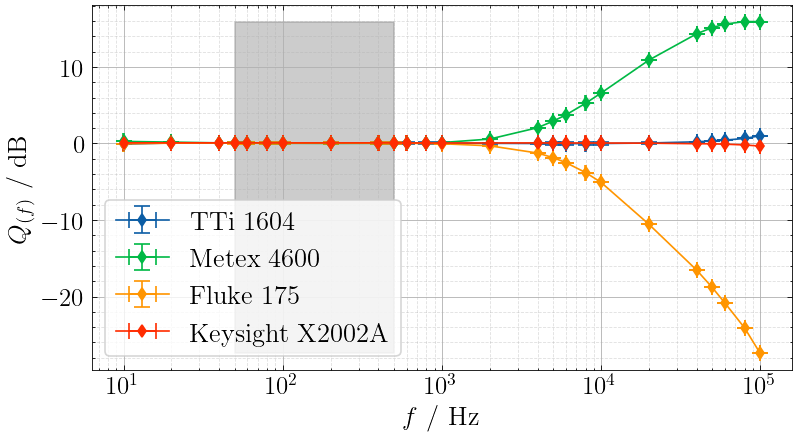

In [304]:
U_ein = 2.07  # Referenz-U_eff aus dem vorigen Versuch
dU_ein = 0.03 #V

# Funktionen für dB-Umrechnung
def to_dB(U):
    return 20 * np.log10(U / U_ein)

def err_to_dB(U, dU):
    return 20/np.log(10) * (dU / U)

# Messwerte → dB
Q_tti    = to_dB(U_tti)
Q_metex  = to_dB(U_metex)
Q_fluke  = to_dB(U_fluke)
Q_oszi   = to_dB(U_Oszi)

# Unsicherheiten → dB
dQ_tti   = err_to_dB(U_tti,  dU_TTI_vals)
dQ_metex = err_to_dB(U_metex, dU_Metex(U_metex, freqency))
dQ_fluke = err_to_dB(U_fluke, dU_Fluke(U_fluke, freqency))


# --- Plot ---
plt.rcParams.update({'font.size': 15})
fig, ax1 = plt.subplots(1,1, figsize=(7,4))

ax1.errorbar(freqency, Q_tti,  xerr=df, yerr=dQ_tti,   fmt="d-", label="TTi 1604",   capsize=5, markersize=5)
ax1.errorbar(freqency, Q_metex,xerr=df, yerr=dQ_metex, fmt="d-", label="Metex 4600", capsize=5, markersize=5)
ax1.errorbar(freqency, Q_fluke,xerr=df, yerr=dQ_fluke, fmt="d-", label="Fluke 175",  capsize=5, markersize=5)
ax1.errorbar(freqency, Q_oszi, xerr=df, fmt="d-", label="Keysight X2002A", capsize=5, markersize=5)

ax1.set_xscale("log")
ax1.set_xlabel(r"$f$ / Hz")
ax1.set_ylabel(r"$Q_{(f)}$ / dB")
ax1.fill_between([50, 500], min(Q_fluke), max(Q_metex), alpha=0.4, color='grey')
ax1.grid(True, ls="--", which="minor", alpha=0.4)
ax1.grid(True, ls="-", which="major", alpha=1)
ax1.legend(loc="lower left", frameon=True, fontsize=16)

plt.tight_layout()

# Versuch 3

In [3]:
U_R = 9.323        # V
U_C = 8.922        # V
dU_C1 = 0.05*U_C
dU_R1 = 0.05*U_R
print(dU_C1, dU_R1)
R   = 68           # Ohm
C   = 47e-6        # F
t_phi = 4.22e-3    # s
T = 20e-3          # s
tan_delta = 0.05

I = U_R / R
R_I = T / (2* np.pi * C * tan_delta)

I_R = U_C / R_I
# I_C = U_C * 2 * np.pi * C / T
I_C = I_R / tan_delta

phi_meas = 2 * np.pi * (t_phi / T)    # rad
phi_meas_deg = np.degrees(phi_meas)

0.44610000000000005 0.46615000000000006


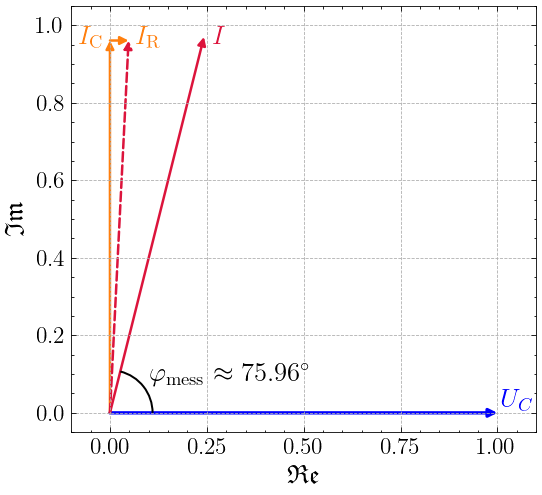

In [ ]:
plt.rcParams.update({
    "font.size": 14,
    "figure.dpi": 120
})

# Separate Skalierungen
Scale_I = 1 / I
Scale_U = 1 / U_C

fig = plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")

plt.grid(True, linestyle="--", alpha=1)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.05, 1.05)

plt.xlabel(r"$\mathfrak{Re}$", fontsize=16)
plt.ylabel(r"$\mathfrak{Im}$", fontsize=16)

arrowstyle = "-|>"
ms = 10

# U_C (blau)
arr_I = FancyArrowPatch(
    (0, 0), 
    (U_C*Scale_U, 0),
    arrowstyle=arrowstyle, color="blue",
    linewidth=2, mutation_scale=ms,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_I)
plt.text(U_C*Scale_U*1.01, 0.015, r"$U_C$", color="blue", fontsize=16)

# I_C (rot)
arr_IC = FancyArrowPatch(
    (0,0),
    (0, I_C*Scale_I),
    arrowstyle=arrowstyle, color="tab:orange",
    linewidth=1.5, mutation_scale=ms,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_IC)
plt.text(-0.08, I_C*Scale_I*0.99, r"$I_\text{C}$", color="tab:orange", fontsize=16)

# Gemessener I (rot)
I_meas_x = I*Scale_I*np.cos(phi_meas)
I_meas_y = I*Scale_I*np.sin(phi_meas)

arr_UL_meas = FancyArrowPatch(
    (0,0), (I_meas_x, I_meas_y),
    arrowstyle=arrowstyle, color="crimson",
    linewidth=1.5, mutation_scale=ms,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_UL_meas)
plt.text(I_meas_x*1.1, I_meas_y*0.98, r"$I$", color="crimson", fontsize=16)

arr_IR = FancyArrowPatch(
    (0,I_C*Scale_I), (I_R*Scale_I, I_C*Scale_I),
    arrowstyle=arrowstyle, color="tab:orange",
    linewidth=1.5, linestyle="-", mutation_scale=ms,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_IR)

# Theoretischer Strom (gestrichelt)
arr_I_theo = FancyArrowPatch(
    (0,0), (I_R*Scale_I, I_C*Scale_I),
    arrowstyle=arrowstyle, color="crimson",
    linewidth=1.5, linestyle="--", 
    mutation_scale=ms, shrinkA=0, shrinkB=0)
ax.add_patch(arr_I_theo)


plt.text(I_R*Scale_I + 0.02, I_C*Scale_I*0.99, r"$I_{\mathrm{R}}$", color="tab:orange", fontsize=16)

# -----------------------------
# Phasenwinkel φ_meas visualisieren
# -----------------------------
arc_radius = 0.11
arc = Arc((0,0),
          2*arc_radius, 2*arc_radius,
          angle=0,
          theta1=0,
          theta2=phi_meas_deg,
          linewidth=1.2,
          color="black")
ax.add_patch(arc)

plt.text(
    arc_radius*1.2*np.cos(phi_meas/2),
    arc_radius*1.2*np.sin(phi_meas/2),
    r"$\varphi_{\mathrm{mess}} \approx %.2f^\circ$" % phi_meas_deg,
    fontsize=16
)

plt.show()


# Versuch 4

In [5]:
U_R = 3.4228        # V
U_L = 12.768        # V
print(U_R*0.05, U_L*0.05)
R = 68              # Ohm
L = 1e-3            # H
t_phi = 4.7e-3         # s
T = 20e-3           # s

R_I = 18.6          #Ohm
dR_I = R_I*0.009 + 0.01
print(dR_I)
I = U_R / R
U_RL = I * R_I
U_XL = np.sqrt(U_L**2 - U_RL**2)

phi_meas = 2 * np.pi * (t_phi / T)    # rad
phi_meas_deg = np.degrees(phi_meas)

0.17114000000000001 0.6384000000000001
0.1774


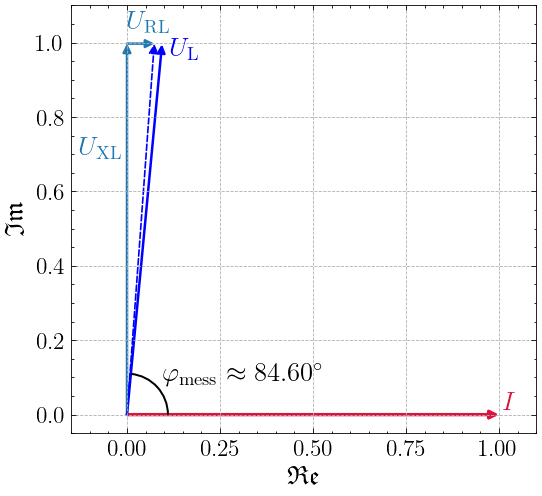

In [140]:
plt.rcParams.update({
    "font.size": 14,
    "figure.dpi": 120
})

# Separate Skalierungen
Scale_I = 1 / I
Scale_U = 1 / U_L


fig = plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")

plt.grid(True, linestyle="--", alpha=1)

ax.set_xlim(-0.15, 1.1)
ax.set_ylim(-0.05, 1.10)

plt.xlabel(r"$\mathfrak{Re}$", fontsize=16)
plt.ylabel(r"$\mathfrak{Im}$", fontsize=16)

arrowstyle = "-|>"
ms = 10

# I (rot)
arr_I = FancyArrowPatch(
    (0, 0), 
    (I*Scale_I, 0),
    arrowstyle=arrowstyle, color="crimson",
    linewidth=2, mutation_scale=ms,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_I)
plt.text(I*Scale_I*1.01, 0.015, r"$I$", color="crimson", fontsize=16)

# Gemessener I (rot)
UL_meas_x = U_L*Scale_U*np.cos(phi_meas)
UL_meas_y = U_L*Scale_U*np.sin(phi_meas)

arr_UL_meas = FancyArrowPatch(
    (0,0), (UL_meas_x, UL_meas_y),
    arrowstyle=arrowstyle, color="blue",
    linewidth=1.5, mutation_scale=ms,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_UL_meas)
plt.text(UL_meas_x*1.23, UL_meas_y*0.97, r"$U_\text{L}$", color="blue", fontsize=16)

# U_XL
arr_UXL = FancyArrowPatch(
    (0,0),
    (0, U_XL*Scale_U),
    arrowstyle=arrowstyle, color="tab:blue",
    linewidth=1.5, mutation_scale=ms,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_UXL)
plt.text(-0.13, U_XL*Scale_U*0.7, r"$U_\text{XL}$", color="tab:blue", fontsize=16)

# U_RL
arr_IR = FancyArrowPatch(
    (0, U_XL*Scale_U), (U_RL*Scale_U, U_XL*Scale_U),
    arrowstyle=arrowstyle, color="tab:blue",
    linewidth=1.5, linestyle="-", mutation_scale=ms,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_IR)
plt.text(0, U_XL*Scale_U*1.04, r"$U_{\mathrm{RL}}$", color="tab:blue", fontsize=16)

arr_theo = FancyArrowPatch(
    (0, 0), (U_RL*Scale_U, U_XL*Scale_U),
    arrowstyle=arrowstyle, color="blue",
    linewidth=1, linestyle="--", mutation_scale=12,
    shrinkA=0, shrinkB=0)
ax.add_patch(arr_theo)

# -----------------------------
# Phasenwinkel φ_meas visualisieren
# -----------------------------
arc_radius = 0.11
arc = Arc((0,0),
          2*arc_radius, 2*arc_radius,
          angle=0,
          theta1=0,
          theta2=phi_meas_deg,
          linewidth=1.2,
          color="black")
ax.add_patch(arc)

plt.text(
    arc_radius*1.2*np.cos(phi_meas/2),
    arc_radius*1.2*np.sin(phi_meas/2),
    r"$\varphi_{\mathrm{mess}} \approx %.2f^\circ$" % phi_meas_deg,
    fontsize=16
)

plt.show()


# Versuch 5

In [83]:
def plot_ZeigerV5(I,U_E, phi_meas, U_R1, U_C1): 
    plt.rcParams.update({
        "font.size": 14,
        "figure.dpi": 120
    })

    Scale_I = 0.8 / I
    Scale_U = 1 / U_E

    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")

    plt.grid(True, linestyle="--", alpha=1)

    ax.set_xlim(-0.15, 1.05)
    ax.set_ylim(-1, 0.15)

    plt.xlabel(r"$\mathfrak{Re}$", fontsize=16)
    plt.ylabel(r"$\mathfrak{Im}$", fontsize=16)

    arrowstyle = "-|>"
    ms = 10

    # I (rot)
    arr_I = FancyArrowPatch(
        (0, 0), 
        (I*Scale_I, 0),
        arrowstyle=arrowstyle, color="crimson",
        linewidth=2, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_I)
    plt.text(I*Scale_I*1.01, 0.015, r"$I$", color="crimson", fontsize=16)

    # Gemessener I (rot)
    UL_meas_x = U_E*Scale_U*np.cos(phi_meas)
    UL_meas_y = U_E*Scale_U*np.sin(phi_meas)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (UL_meas_x, -UL_meas_y),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)
    plt.text(UL_meas_x*1.05, -UL_meas_y*1.05, r"$U_\text{E}$", color="blue", fontsize=16)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (U_R1*Scale_U, 0),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)
    plt.text(0.4, 0.028, r"$U_\text{R1}$", color="blue", fontsize=16)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (0, -U_C1*Scale_U),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)
    plt.text(-0.115,-0.5, r"$U_\text{C1}$", color="blue", fontsize=16)


    arr_UL_meas = FancyArrowPatch(
        (0,0), (U_R1*Scale_U, -U_C1*Scale_U),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1, mutation_scale=12,
        shrinkA=0, shrinkB=0, linestyle='--')
    ax.add_patch(arr_UL_meas)

    # -----------------------------
    # Phasenwinkel φ_meas visualisieren
    # -----------------------------
    arc_radius = 0.11
    arc = Arc((0,0),
            2*arc_radius, 2*arc_radius,
            angle=0,
            theta2=0,
            theta1=-phi_meas_deg,
            linewidth=1.2,
            color="black")
    ax.add_patch(arc)

    plt.text(
        arc_radius*1.2*np.cos(phi_meas/2),
        -arc_radius*1.7*np.sin(phi_meas/2),
        r"$\varphi \approx %.2f^\circ$" % phi_meas_deg,
        fontsize=16
    )

    plt.show()

In [117]:
def plot_LeistungsdreieckV5(P,Q,S,phi_meas):
    plt.rcParams.update({
        "font.size": 14,
        "figure.dpi": 120
    })

    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()

    plt.grid(True, linestyle="--", alpha=1)

    ax.set_xlim(-0.1, 0.8)
    ax.set_ylim(-0.15, 1.1)

    plt.xlabel(r"$P$ / W", fontsize=16)
    plt.ylabel(r"$Q$ / Var", fontsize=16)

    arrowstyle = "-|>"
    ms = 10

    # I (rot)
    arr_I = FancyArrowPatch(
        (0, 0), 
        (P, 0),
        arrowstyle=arrowstyle, color="crimson",
        linewidth=2, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_I)

    arr_UL_meas = FancyArrowPatch(
        (P,0), (P, Q),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (P, Q),
        arrowstyle=arrowstyle, color="black",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)

    plt.text(0.3, -0.08, r"$P$", color="crimson", fontsize=16)
    plt.text(0.6, 0.45, r"$Q$", color="blue", fontsize=16)
    plt.text(0.3, 0.45, r"$S$", color="black", fontsize=16)

    # -----------------------------
    # Phasenwinkel φ_meas visualisieren
    # -----------------------------
    arc_radius = 0.11
    arc = Arc((0,0),
            2*arc_radius, 2*arc_radius,
            angle=0,
            theta1=0,
            theta2=phi_meas_deg,
            linewidth=1.2,
            color="black")
    ax.add_patch(arc)

    plt.text(
        arc_radius*1.2*np.cos(phi_meas/2),
        arc_radius*1.2*np.sin(phi_meas/2),
        r"$\varphi$", fontsize=16
    )
    plt.show()

In [128]:
U_C1 = 12.18    #V
U_R1 = 5.739    #V
dU_C1 = 0.01*U_C1 + 0.03
dU_R1 = 0.01*U_R1 + 0.003

U_E = 13.8      #V
I = 85e-3       #A
dU_E = U_E*0.004 + 0.5
dI = I*0.004 + 0.05e-3

print(U_C1, dU_C1)
print(U_R1, dU_R1)
print(U_E, dU_E)
print(I,dI)

C = 20e-6       #F

t_phi = 3.38e-3  #s
dt_phi = 0.25e-3 #s
T = 20e-3        #s

phi_meas = 2 * np.pi * (t_phi / T)    # rad
dphi = 2*np.pi * (dt_phi /T) # rad
phi_meas_deg = np.degrees(phi_meas)

# plot_ZeigerV5(I, U_E, phi_meas, U_R1, U_C1)

12.18 0.1518
5.739 0.06039
13.8 0.5552
0.085 0.00039000000000000005


In [129]:
S = U_E * I
dS = S* (dU_E / U_E + dI / I)

P = S*np.cos(phi_meas)
dP = dS * np.cos(phi_meas) + S*np.sin(phi_meas)*dphi

Q = S*np.sin(phi_meas) 
dQ = dS * np.sin(phi_meas) + S*np.cos(phi_meas)*dphi

print("Leistungen")
print(S, dS, " VA") 
print(P, dP, " W") 
print(Q, dQ, " Var")

# plot_LeistungsdreieckV5(P,Q,S,phi_meas)

Leistungen
1.173 0.052574  VA
0.5715443974758148 0.10606791692441915  W
1.0243368594920363 0.09079989230693736  Var


In [107]:
cos_phi2 = np.cos(np.atan(U_C1/U_R1))
dcos_phi2 = cos_phi2**3 * U_C1 / U_R1 * (dU_C1 + dU_R1/(U_R1**2))

PF = 0.566   
dPF = PF*0.02 + 0.003

print("\nVergleich Phase")
print(np.cos(phi_meas), np.sin(phi_meas)*dphi)
print(cos_phi2, dcos_phi2)
print(PF, dPF)


Vergleich Phase
0.4872501257253322 0.06858587281716584
0.4262369267320338 0.025249358154874516
0.566 0.01432


# Versuch 6

In [46]:
def plot_ZeigerV6(I,U_E, phi_meas, U_R1, U_L1): 
    plt.rcParams.update({
        "font.size": 14,
        "figure.dpi": 120
    })

    Scale_I = 0.8 / I
    Scale_U = 1 / U_E

    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")

    plt.grid(True, linestyle="--", alpha=1)

    ax.set_xlim(-0.15, 1)
    ax.set_ylim(-0.15, 1)

    plt.xlabel(r"$\mathfrak{Re}$", fontsize=16)
    plt.ylabel(r"$\mathfrak{Im}$", fontsize=16)

    arrowstyle = "-|>"
    ms = 10

    # I (rot)
    arr_I = FancyArrowPatch(
        (0, 0), 
        (I*Scale_I, 0),
        arrowstyle=arrowstyle, color="crimson",
        linewidth=2, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_I)
    plt.text(I*Scale_I*1.01, 0.015, r"$I$", color="crimson", fontsize=16)

    # Gemessener I (rot)
    UL_meas_x = U_E*Scale_U*np.cos(phi_meas)
    UL_meas_y = U_E*Scale_U*np.sin(phi_meas)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (UL_meas_x, UL_meas_y),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)
    plt.text(UL_meas_x*1.03, UL_meas_y*1.03, r"$U_\text{E}$", color="blue", fontsize=16)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (U_R1*Scale_U, 0),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)
    plt.text(0.23, -0.07, r"$U_\text{R1}$", color="blue", fontsize=16)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (0, U_L1*Scale_U),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)
    plt.text(-0.115,0.54, r"$U_\text{L1}$", color="blue", fontsize=16)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (U_R1*Scale_U, U_L1*Scale_U),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1, mutation_scale=12,
        shrinkA=0, shrinkB=0, linestyle='--')
    ax.add_patch(arr_UL_meas)

    arc_radius = 0.11
    arc = Arc((0,0),
            2*arc_radius, 2*arc_radius,
            angle=0,
            theta1=0,
            theta2=phi_meas_deg,
            linewidth=1.2,
            color="black")
    ax.add_patch(arc)

    plt.text(
        arc_radius*1.2*np.cos(phi_meas/2),
        arc_radius*1.2*np.sin(phi_meas/2),
        r"$\varphi \approx %.2f^\circ$" % phi_meas_deg,
        fontsize=16
    )

    plt.show()
    return fig

In [113]:
def plot_LeistungsdreieckV6(P,Q,S,phi_meas):
    plt.rcParams.update({
        "font.size": 14,
        "figure.dpi": 120
    })

    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()

    plt.grid(True, linestyle="--", alpha=1)

    ax.set_xlim(-0.1, 0.5)
    ax.set_ylim(-0.1, 0.7)

    plt.xlabel(r"$P$ / W", fontsize=16)
    plt.ylabel(r"$Q$ / Var", fontsize=16)

    arrowstyle = "-|>"
    ms = 10

    # I (rot)
    arr_I = FancyArrowPatch(
        (0, 0), 
        (P, 0),
        arrowstyle=arrowstyle, color="crimson",
        linewidth=2, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_I)

    arr_UL_meas = FancyArrowPatch(
        (P,0), (P, Q),
        arrowstyle=arrowstyle, color="blue",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)

    arr_UL_meas = FancyArrowPatch(
        (0,0), (P, Q),
        arrowstyle=arrowstyle, color="black",
        linewidth=1.5, mutation_scale=ms,
        shrinkA=0, shrinkB=0)
    ax.add_patch(arr_UL_meas)

    plt.text(0.15, -0.05, r"$P$", color="crimson", fontsize=16)
    plt.text(0.31, 0.26, r"$Q$", color="blue", fontsize=16)
    plt.text(0.15, 0.26, r"$S$", color="black", fontsize=16)

    # -----------------------------
    # Phasenwinkel φ_meas visualisieren
    # -----------------------------
    arc_radius = 0.11
    arc = Arc((0,0),
            2*arc_radius, 2*arc_radius,
            angle=0,
            theta1=0,
            theta2=phi_meas_deg,
            linewidth=1.2,
            color="black")
    ax.add_patch(arc)

    plt.text(
        arc_radius*1.2*np.cos(phi_meas/2),
        arc_radius*1.2*np.sin(phi_meas/2),
        r"$\varphi$",
        fontsize=16
    )

    plt.show()

In [124]:
U_L1 = 13.13    #V
U_R1 = 3.406    #V
dU_L1 = 0.01*U_L1 + 0.03
dU_R1 = 0.01*U_R1 + 0.003

U_E = 13.9      #V
I = 50e-3       #A
dU_E = 0.004*U_E + 0.5
dI = 0.004*I + 0.05e-3

print(U_L1, dU_C1)
print(U_R1, dU_R1)
print(U_E, dU_E)
print(I,dI)

L = 1e-3        #H
# t_phi = 2.94e-3  #s
t_phi = 3.64e-3  #s
dt_phi = 0.25e-3 #s
T = 20e-3        #s

phi_meas = 2 * np.pi * (t_phi / T)    # rad
dphi = 2*np.pi * (dt_phi /T) # rad
phi_meas_deg = np.degrees(phi_meas)

#f = plot_ZeigerV6(I,U_E, phi_meas, U_R1, U_L1)

13.13 0.1518
3.406 0.03706
13.9 0.5556
0.05 0.00025


In [125]:
S = U_E * I
dS = S* (dU_E / U_E + dI / I)

P = S*np.cos(phi_meas)
dP = dS * np.cos(phi_meas) + S*np.sin(phi_meas)*dphi

Q = S*np.sin(phi_meas) 
dQ = dS * np.sin(phi_meas) + S*np.cos(phi_meas)*dphi

print("Leistungen")
print(S, dS, " VA") 
print(P, dP, " W") 
print(Q, dQ, " Var")

# plot_LeistungsdreieckV6(P, Q, S, phi_meas)

Leistungen
0.6950000000000001 0.031255  VA
0.28799102879033256 0.06262960005612189  W
0.632523649626072 0.05106412462244642  Var


In [110]:
cos_phi2 = np.cos(np.atan(U_L1/U_R1))
dcos_phi2 = cos_phi2**3 * U_L1 / U_R1 * (dU_L1 + dU_R1/(U_R1**2))

PF = 0.251    #Watt
dPF = PF*0.02 + 0.003

print("\nVergleich Phase")
print(np.cos(phi_meas), np.sin(phi_meas)*dphi)
print(cos_phi2, dcos_phi2)
print(PF, dPF)


Vergleich Phase
0.41437558099328425 0.07147955578730475
0.2510951961178569 0.010038918605590997
0.251 0.00802


# Versuch 7

In [131]:
# C=100 muF
U_E = 12.8   #V
I = 0.148    #A
U_C = 5.167  #V
I_C = 0.065  #A
U_R1 = 10.03 #V

dU_C = 0.01*U_C + 0.003
dI_C = 0.004*I_C + 0.004
dU_R1 = 0.01*U_R1 + 0.03

dU_E = 0.004*U_E + 0.5
dI = 0.004*I + 0.005

t1_phi = 1.9e-3  #s
t2_phi = 0.84e-3  #s
t3_phi = 1.02e-3  #s
dt_phi = 0.25e-3 #s
T = 20e-3        #s

phi1_meas = 2 * np.pi * (t1_phi / T)    # rad
phi2_meas = 2 * np.pi * (t2_phi / T)    # rad
phi3_meas = 2 * np.pi * (t3_phi / T)    # rad

dphi = 2*np.pi * (dt_phi /T) # rad
print(np.degrees(dphi))
print(np.cos(phi1_meas), np.sin(phi1_meas)*dphi) #C=100 mF
print(np.cos(phi2_meas), np.sin(phi2_meas)*dphi) #C=177 mF
print(np.cos(phi3_meas), np.sin(phi3_meas)*dphi) #C=167 mF

4.5
0.8270805742745618 0.044145925264129734
0.9653816388332739 0.020486443997790902
0.9490961449902946 0.02473898340322306
